In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json 
import math
import scipy as sc
from itertools import islice
from random import sample
seed = 0

In [4]:
def get_network_mcf_json(fp: str, link_capacity: int) -> nx.Graph:

    with open(fp, mode='r') as file:
        in_data = json.load(file)

    G = nx.node_link_graph(in_data)
    nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)
    nx.set_edge_attributes(G, link_capacity, "available_capacity")
    
    return G

In [5]:
from typing import List, Tuple 

def generate_demands(G: nx.Graph, total_flow: int, sort_them: bool, discrete: bool) -> List[Tuple[int, int, int]]:
    #Initialize an empty list demands
    demands = []
    nodes = G.nodes()
    for i in range(total_flow):          #For each iteration in the range of total_flow:
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)  #Randomly select two distinct nodes, src and dst, from the nodes in graph G
        rate = np.random.randint(1, 10) * 100 if discrete else np.random.randint(100, 1000)
        demands.append((src, dst, rate))     #Append the tuple (src, dst) to the demands list
    # sort them in decreasing rate
    if sort_them:
        demands.sort(key=lambda x: x[2], reverse=True)

    return demands   #Return the demands list

In [6]:
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict[tuple[int, int]: list[int]]:
    
    ksp = {}                #Initialize an empty dictionary ksp
    for i in G.nodes:       #For each node i in the graph G:
        for j in G.nodes:   #For each node j in the graph G:
            if i < j:       #If i is less than j:
                            #Find the first n_paths shortest paths between nodes i and j in G using the specified metric
                paths = list(islice(nx.shortest_simple_paths(G, i, j, metric), n_paths))
                ksp[i, j] = paths
                ksp[j, i] = paths
                
    return ksp  #Return the dictionary ksp

In [7]:
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [8]:
def get_network_rwa_json_dualband(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    c_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths
    l_available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        c_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8
        l_available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8
        G[edge[0]][edge[1]]["c_amplifiers"] = 0
        G[edge[0]][edge[1]]["l_amplifiers"] = 0
        
    nx.set_edge_attributes(G, c_available_wavelengths, "c_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    nx.set_edge_attributes(G, l_available_wavelengths, "l_available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["c_n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths
    G.graph["l_n_wavelengths"] = n_wavelengths                                           #Set the graph attribute "n_wavelengths" in G to n_wavelengths
    
    nx.set_node_attributes(G, 0, "crossband_regenerators")
    nx.set_node_attributes(G, 0, "monoband_regenerators")
    return G                            #Return the graph G 

In [9]:
def allocateSpecial(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band=None) -> tuple[tuple, int]:
    if band == "C-band":
        available_wavelengths = "c_available_wavelengths"
        n_wavelengths = "c_n_wavelengths"
    elif band == "L-band":
        available_wavelengths = "l_available_wavelengths"
        n_wavelengths = "l_n_wavelengths"
    else:
        available_wavelengths = "available_wavelengths"
        n_wavelengths = "n_wavelengths"
        band = "None"
    
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        # Use the sum of available wavelengths as the weight
        utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        if utilized_wavelengths == 96:
            return math.inf
        return utilized_wavelengths if available_wavelengths in data else float('inf')
    
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    # find the shortest path using networkx library and basing on the metric in order to maximize the number of available wavelength on the link with less available wavelengths
    #path = nx.shortest_path(G, src, dst, weight='n_used_wavelengths')
    possible_mods = []
    longest_link = 0
    total_path_length = 0  
    routed = False
    utilized_wavelengths = 0

    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            total_path_length += G[path[i]][path[i + 1]]["length"]

    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves <= bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    available_waves_c = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
    upto = len(path) - 1  # Assume initially that the entire path is valid
    upto_back = 0
    for i in range(len(path) - 1):
        temp_available_waves_c = []  # Temporary list for this link
        for wav in available_waves_c:  # Check only wavelengths that are already available
            if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1:
                temp_available_waves_c.append(wav)

        # If at any point the number of wavelengths is insufficient, stop
        if len(temp_available_waves_c) < bestModWaves:
            upto = i  # Record the last valid link
            break
        # Update the list of available wavelengths for the path so far
        available_waves_c = temp_available_waves_c
    
    if upto > 0:
        if upto == len(path) - 1:  # FULLY C-BAND
            band = "C-band"
            for wav in available_waves_c[:bestModWaves]:
                partial_dist = 0
                for i in range(len(path) - 1):
                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                    utilized_wavelengths += 1

                    partial_dist += G[path[i]][path[i + 1]]["length"]
                    if partial_dist >= bestMod["Reach (km)"]:
                        G.nodes[path[i]]["monoband_regenerators"] += 1
                        partial_dist = G[path[i]][path[i + 1]]["length"]

            return (src, dst, path, available_waves_c[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths
        else:
            # COMPUTE UPTO_BACK
            available_waves_c_back = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
            for i in range(len(path) - 1, 0, -1):
                temp_available_waves_c = []
                for wav in available_waves_c_back:
                    if G[path[i]][path[i - 1]]["c_available_wavelengths"][wav] == 1:
                        temp_available_waves_c.append(wav)
                
                if len(temp_available_waves_c) < bestModWaves:
                    upto_back = i
                    break
                available_waves_c_back = temp_available_waves_c

        if upto_back <= upto: # C-BAND 1 JUMP
            band = 'C-double'
            for wav in available_waves_c[:bestModWaves]:
                partial_dist = 0
                for i in range(upto - 1):  
                    # Assert that the wavelength is indeed free and then mark it as used
                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                    utilized_wavelengths += 1
                    
                    partial_dist += G[path[i]][path[i + 1]]["length"]
                    if partial_dist >= bestMod["Reach (km)"]:
                        G.nodes[path[i]]["monoband_regenerators"] += 1
                        partial_dist = G[path[i]][path[i + 1]]["length"]

            for wav in available_waves_c_back[:bestModWaves]:
                partial_dist = 0
                for i in range(upto, len(path) - 1):
                    assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                    G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                    utilized_wavelengths += 1

                    partial_dist += G[path[i]][path[i + 1]]["length"]
                    if partial_dist >= bestMod["Reach (km)"]:
                        G.nodes[path[i]]["monoband_regenerators"] += 1
                        partial_dist = G[path[i]][path[i + 1]]["length"]
            
            G.nodes[path[upto]]["monoband_regenerators"] += bestModWaves

            
            waves_of_path = {   'C-band' : {'edges' : path[:(upto+1)],
                                        'wavelengths' : available_waves_c[:bestModWaves]},
                                'C-back' : {'edges' : path[upto:],
                                        'wavelengths' : available_waves_c_back[:bestModWaves]}
                            }
            
            return (src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths

    return None, None


In [10]:
def allocateSpecialLband(G: nx.Graph, src: int, dst: int, rate: int, modTable: dict, band='L-band') -> tuple[tuple, int]:

    available_wavelengths = "l_available_wavelengths"
    n_wavelengths = "l_n_wavelengths"
   
    # Define a custom weight function for the shortest path algorithm
    # def wavelength_weight(u, v, data):
    #     utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        
    #     if utilized_wavelengths == 96:
    #         return math.inf
    #     elif utilized_wavelengths > 0 and utilized_wavelengths < 96:
    #         return utilized_wavelengths
    #     return 99999 if available_wavelengths in data else float('inf') 
    #     # not infinite otherwise not used
    
    # Define a custom weight function for the shortest path algorithm
    def wavelength_weight(u, v, data):
        # Use the sum of available wavelengths as the weight
        utilized_wavelengths = len(data[available_wavelengths])-sum(data[available_wavelengths])
        if utilized_wavelengths == 96:
            return math.inf
        return utilized_wavelengths if available_wavelengths in data else float('inf')
    
    # Find the shortest path based on the custom weight
    path = nx.shortest_path(G, src, dst, weight=wavelength_weight)
    if path == None:
        return None, None
    possible_mods = []
    longest_link = 0
    total_path_length = 0

    for i in range(len(path) - 1):
        if "length" in G[path[i]][path[i + 1]]:
            longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
            total_path_length += G[path[i]][path[i + 1]]["length"]
    for mod in modTable:
        if longest_link <= mod["Reach (km)"]:
            possible_mods.append(mod)
            
    available_waves = []
    for wav in range(G.graph[n_wavelengths]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
        is_wavelength_free = True

        for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
            # Check if the current wavelength is free along the entire path
            if G[path[i]][path[i + 1]][available_wavelengths][wav] == 0:
                is_wavelength_free = False
                break

        if is_wavelength_free:
            available_waves.append(wav)
    
    # Find the best modulation by choosing the one using the fewer number of wavelengths
    bestMod = None
    bestModWaves = math.inf
    for mod in possible_mods:
        modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
        if modNeededWaves <= bestModWaves or bestMod == None:
            bestMod = mod
            bestModWaves = modNeededWaves
    bestModWaves = int(bestModWaves) 

    utilized_wavelengths = 0
    if len(available_waves) >= bestModWaves:
        for wav in available_waves[:bestModWaves]:
            partial_dist = 0
            for i in range(len(path) - 1):
                # Assert that the wavelength is indeed free and then mark it as used
                assert G[path[i]][path[i + 1]][available_wavelengths][wav] == 1
                G[path[i]][path[i + 1]][available_wavelengths][wav] = 0
                utilized_wavelengths += 1

                partial_dist += G[path[i]][path[i + 1]]["length"]
                if partial_dist >= bestMod["Reach (km)"]:
                    G.nodes[path[i]]["monoband_regenerators"] += 1
                    partial_dist = G[path[i]][path[i + 1]]["length"]

        return (src, dst, path, available_waves[:bestModWaves], bestMod["Data Rate (Gb/s)"], band) , utilized_wavelengths
    else:
        return None, None


In [11]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband(G: nx.Graph, demands: list, ksp: dict, modTable: list, cumulative_total: int, cumulative_lost: int) -> tuple[int, list, int, int, int, int]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    routed_demands = []
    one_percent = None
    if cumulative_total != 0:
        if cumulative_lost / cumulative_total < 0.01:
            one_percent = None
        else:
            one_percent = cumulative_lost / cumulative_total * 100
    give_percent = False

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0 
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    lost_traffic = 0
    demand_index = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
        demand_index += 1  
        routed = False

        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []
            possible_mods = []
            longest_link = 0
            total_path_length = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    total_path_length += G[path[i]][path[i + 1]]["length"]
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves <= bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)
            
            available_waves_c = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
            upto = len(path) - 1  # Assume initially that the entire path is valid
            upto_back = 0
            for i in range(len(path) - 1):
                temp_available_waves_c = []  # Temporary list for this link
                for wav in available_waves_c:  # Check only wavelengths that are already available
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1:
                        temp_available_waves_c.append(wav)

                # If at any point the number of wavelengths is insufficient, stop
                if len(temp_available_waves_c) < bestModWaves:
                    upto = i  # Record the last valid link
                    break
                # Update the list of available wavelengths for the path so far
                available_waves_c = temp_available_waves_c
            
            if upto > 0:
                if upto == len(path) - 1:  # FULLY C-BAND
                    band = "C-band"
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(len(path) - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    # Record the routed demand information
                    n_c_routed_demands += 1
                    total_routed_traffic_c += rate
                    routed_demands.append((src, dst, path, available_waves_c[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in full C-band: \n {routed_demands[-1]}\n')
                    routed = True
                    break
                else:
                    # COMPUTE UPTO_BACK
                    available_waves_c_back = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                    for i in range(len(path) - 1, 0, -1):
                        temp_available_waves_c = []
                        for wav in available_waves_c_back:
                            if G[path[i]][path[i - 1]]["c_available_wavelengths"][wav] == 1:
                                temp_available_waves_c.append(wav)
                        
                        if len(temp_available_waves_c) < bestModWaves:
                            upto_back = i
                            break
                        available_waves_c_back = temp_available_waves_c

                if upto_back <= upto: # C-BAND 1 JUMP
                    band = 'C-double'
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1
                            
                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_c_back[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto, len(path) - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]
                    
                    G.nodes[path[upto]]["monoband_regenerators"] += bestModWaves

                    # Record the routed demand information
                    n_c_routed_demands += 1
                    total_routed_traffic_c += rate
                    
                    waves_of_path = {   'C-band' : {'edges' : path[:(upto+1)],
                                                'wavelengths' : available_waves_c[:bestModWaves]},
                                        'C-back' : {'edges' : path[upto:],
                                                'wavelengths' : available_waves_c_back[:bestModWaves]}
                                    }
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in C-band (1 jump): \n {routed_demands[-1]}\n')

                    routed = True
                    break
        if routed == False:
            band = "C-band"
            # try using a dedicated routine to allocate it
            specialRoute, nUsedWaves = allocateSpecial(G, src, dst, rate, modTable, band)
            if specialRoute != None:
                n_c_routed_demands += 1
                num_c_utilized_wavelengths += nUsedWaves
                total_routed_traffic_c += rate
                routed_demands.append(specialRoute)
                #print(f'Demand {demand_index} routed in C-band special: \n {routed_demands[-1]}\n')
                routed = True
                #break
            else:
                band = "L-band"
                # First I try allocating on already existing L band link:
                specialRouteLband, nUsedWaves = allocateSpecialLband(G, src, dst, rate, modTable)
                if specialRouteLband != None:
                    n_l_routed_demands += 1
                    num_l_utilized_wavelengths += nUsedWaves
                    total_routed_traffic_l += rate
                    
                    routed_demands.append(specialRouteLband)
                    #print(f'Demand {demand_index} routed in L-band special: \n {routed_demands[-1]}\n')
                    #break
                    routed = True

        if routed == False:
            #print(f'Demand {demand_index}: [{src} -> {dst}] could not be routed')
            lost_traffic += rate
            lost_percentage = (cumulative_lost + lost_traffic) / (cumulative_total + total_routed_traffic_c + total_routed_traffic_l) * 100
            
            if one_percent == None and lost_percentage >= 1:
                one_percent = demand_index
                give_percent = True
                    
                
                
    # Print summary
    #print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    #print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    #print("Number of utilized wavelengths:", num_utilized_wavelengths)
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l
    #print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    #print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band and {total_routed_traffic_l} Gbps in the L-band')
    n_routed_demands = n_c_routed_demands + n_l_routed_demands
    #print(routed_demands)

    if give_percent:
        return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, lost_traffic, one_percent
    return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, lost_traffic, None

In [12]:
# adapting sap_ff_rwa_variable function to the dual band case such that if not enough available wavelengths are found in the c-band, the l-band is checked
def sap_ff_rwa_variable_mod_dualband_crossband_2(G: nx.Graph, demands: list, ksp: dict, modTable: list, cumulative_total: int, cumulative_lost: int) -> tuple[int, list, int, int, int, int, int, int, int]:
    
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    n_c_routed_demands = 0
    n_l_routed_demands = 0
    n_c_AND_l_routed_demands = 0
    routed_demands = []
    one_percent = None
    if cumulative_total != 0:
        if cumulative_lost / cumulative_total < 0.01:
            one_percent = None
        else:
            one_percent = cumulative_lost / cumulative_total * 100
    give_percent = False

    num_c_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_l_utilized_wavelengths = 0
    num_utilized_wavelengths = 0
    total_traffic = sum([rate for src, dst, rate in demands])
    total_routed_traffic_l = 0
    total_routed_traffic_c = 0
    total_routed_traffic_c_AND_l = 0

    lost_traffic = 0
    demand_index = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
        demand_index += 1    
        routed = False
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            possible_mods = []
            longest_link = 0
            total_path_length = 0

            for i in range(len(path) - 1):
                if "length" in G[path[i]][path[i + 1]]:
                    longest_link = max(longest_link, G[path[i]][path[i + 1]]["length"])
                    total_path_length += G[path[i]][path[i + 1]]["length"] 
            for mod in modTable:
                if longest_link <= mod["Reach (km)"]:
                    possible_mods.append(mod)

            # Find the best modulation by choosing the one using the fewer number of wavelengths
            bestMod = None
            bestModWaves = math.inf
            for mod in possible_mods:
                modNeededWaves = (rate // mod["Data Rate (Gb/s)"] + 1) * (mod["Channel spacing (Δf) (GHz)"] / 50)
                if modNeededWaves <= bestModWaves or bestMod == None:
                    bestMod = mod
                    bestModWaves = modNeededWaves
            bestModWaves = int(bestModWaves)       
             
            available_waves_c = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
            upto = len(path) - 1  # Assume initially that the entire path is valid
            upto_back = 0
            upto_l = len(path) - 1
            upto_l_back = 0

            for i in range(len(path) - 1):
                temp_available_waves_c = []  # Temporary list for this link
                for wav in available_waves_c:  # Check only wavelengths that are already available
                    if G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1:
                        temp_available_waves_c.append(wav)

                # If at any point the number of wavelengths is insufficient, stop
                if len(temp_available_waves_c) < bestModWaves:
                    upto = i  # Record the last valid link
                    break
                # Update the list of available wavelengths for the path so far
                available_waves_c = temp_available_waves_c
            
            if upto > 0:
                if upto == len(path) - 1:  # FULLY C-BAND
                    band = "C-band"
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(len(path) - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    # Record the routed demand information
                    n_c_routed_demands += 1
                    total_routed_traffic_c += rate
                    routed_demands.append((src, dst, path, available_waves_c[:bestModWaves], bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in full C-band: \n {routed_demands[-1]}\n')
                    routed = True
                    break
                else:
                    # COMPUTE UPTO_BACK
                    available_waves_c_back = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                    for i in range(len(path) - 1, 0, -1):
                        temp_available_waves_c = []
                        for wav in available_waves_c_back:
                            if G[path[i]][path[i - 1]]["c_available_wavelengths"][wav] == 1:
                                temp_available_waves_c.append(wav)
                        
                        if len(temp_available_waves_c) < bestModWaves:
                            upto_back = i
                            break
                        available_waves_c_back = temp_available_waves_c

                if upto_back <= upto: # C-BAND 1 JUMP
                    band = 'C-double'
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1
                            
                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_c_back[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto, len(path) - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]
                    
                    G.nodes[path[upto]]["monoband_regenerators"] += bestModWaves

                    # Record the routed demand information
                    n_c_routed_demands += 1
                    total_routed_traffic_c += rate
                    
                    waves_of_path = {   'C-band' : {'edges' : path[:(upto+1)],
                                                'wavelengths' : available_waves_c[:bestModWaves]},
                                        'C-back' : {'edges' : path[upto:],
                                                'wavelengths' : available_waves_c_back[:bestModWaves]}
                                    }
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in C-band (1 jump): \n {routed_demands[-1]}\n')

                    routed = True
                    break
                else:  # COMPUTE UPTO_L FROM UPTO
                    available_waves_l = list(range(G.graph["l_n_wavelengths"]))
                    for i in range(upto,len(path) - 1):
                        temp_available_waves_l = []  # Temporary list for this link
                        for wav in available_waves_l:  # Check only wavelengths that are already available
                            if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                                temp_available_waves_l.append(wav)

                        # If at any point the number of wavelengths is insufficient, stop
                        if len(temp_available_waves_l) < bestModWaves:
                            upto_l = i  # Record the last valid link
                            break
                        # Update the list of available wavelengths for the path so far
                        available_waves_l = temp_available_waves_l
                
                if upto_back == len(path) - 1 and upto_l == len(path) - 1: # C+L BAND
                    band = 'C+L-band'
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_l[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto, len(path) - 1):
                            assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    G.nodes[path[upto]]["crossband_regenerators"] += bestModWaves

                    # Record the routed demand information
                    n_c_AND_l_routed_demands += 1
                    total_routed_traffic_c_AND_l += rate
                    
                    waves_of_path = { 'C-band' : {'edges' : path[:(upto+1)],
                                                    'wavelengths' : available_waves_c[:bestModWaves]},
                                        'L-band' : {'edges' : path[upto:],
                                                    'wavelengths' : available_waves_l[:bestModWaves]}
                                    }
                    
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in C+L-band: \n {routed_demands[-1]}\n')

                    routed = True
                    break
                elif upto_l > upto_back and upto_l!= upto: # C+L+C BAND
                    band = 'C+L-band'
                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_l[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto, upto_back - 1):
                            assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_c_back[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_back, len(path) - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    G.nodes[path[upto]]["crossband_regenerators"] += bestModWaves
                    G.nodes[path[upto_back]]["crossband_regenerators"] += bestModWaves
                    

                    # Record the routed demand information
                    n_c_AND_l_routed_demands += 1
                    total_routed_traffic_c_AND_l += rate
                    
                    waves_of_path = {   'C-band' : {'edges' : path[:(upto+1)],
                                                    'wavelengths' : available_waves_c[:bestModWaves]},
                                        'L-band' : {'edges' : path[upto:upto_back+1],
                                                    'wavelengths' : available_waves_l[:bestModWaves]},
                                        'C-back' : {'edges' : path[upto_back:],
                                                    'wavelengths' : available_waves_c_back[:bestModWaves]}
                                    }
                    
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in C+L+C-band: \n {routed_demands[-1]}\n')

                    routed = True
                    break

            else: # COMPUTE UPTO_L FROM 0
                available_waves_l = list(range(G.graph["l_n_wavelengths"]))
                for i in range(len(path) - 1):
                    temp_available_waves_l = []  # Temporary list for this link
                    for wav in available_waves_l:  # Check only wavelengths that are already available
                        if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                            temp_available_waves_l.append(wav)

                    # If at any point the number of wavelengths is insufficient, stop
                    if len(temp_available_waves_l) < bestModWaves:
                        upto_l = i  # Record the last valid link
                        break
                    # Update the list of available wavelengths for the path so far
                    available_waves_l = temp_available_waves_l

                # COMPUTE UPTO_C_BACK
                available_waves_c_back = list(range(G.graph["c_n_wavelengths"]))  # Start with all wavelengths available
                for i in range(len(path) - 1, 0, -1):
                    temp_available_waves_c = []
                    for wav in available_waves_c_back:
                        if G[path[i]][path[i - 1]]["c_available_wavelengths"][wav] == 1:
                            temp_available_waves_c.append(wav)
                    
                    if len(temp_available_waves_c) < bestModWaves:
                        upto_back = i
                        break
                    available_waves_c_back = temp_available_waves_c
                
                if upto_back <= upto_l and upto_l != 0 and upto_back != len(path) - 1: # L+C BAND
                    band = 'C+L-band'
                    for wav in available_waves_l[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_back - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_c_back[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_back, len(path) - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    G.nodes[path[upto_back]]["crossband_regenerators"] += bestModWaves

                    # Record the routed demand information
                    n_c_AND_l_routed_demands += 1
                    total_routed_traffic_c_AND_l += rate
                    
                    waves_of_path = {   'L-band' : {'edges' : path[:upto_back + 1],
                                                    'wavelengths' : available_waves_l[:bestModWaves]}, 
                                        'C-band' : {'edges' : path[upto_back:],
                                                    'wavelengths' : available_waves_c_back[:bestModWaves]},
                                    }
                    
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in L+C-band: \n {routed_demands[-1]}\n')
                    routed = True
                    break

                else: # COMPUTE L_BACK
                    
                    available_waves_l_back = list(range(G.graph["l_n_wavelengths"]))
                    for i in range(len(path) - 1):
                        temp_available_waves_l = []  # Temporary list for this link
                        for wav in available_waves_l:  # Check only wavelengths that are already available
                            if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                                temp_available_waves_l.append(wav)

                        # If at any point the number of wavelengths is insufficient, stop
                        if len(temp_available_waves_l) < bestModWaves:
                            upto_l_back = i  # Record the last valid link
                            break
                        # Update the list of available wavelengths for the path so far
                        available_waves_l_back = temp_available_waves_l
                    
                    # COMPUTE UPTO_C FROM UPTO_L
                    upto_c = len(path) - 1
                    
                    available_waves_c = list(range(G.graph["c_n_wavelengths"]))
                    for i in range(upto_l,len(path) - 1):
                        temp_available_waves_c = []  # Temporary list for this link
                        for wav in available_waves_c:  # Check only wavelengths that are already available
                            if G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1:
                                temp_available_waves_c.append(wav)

                        # If at any point the number of wavelengths is insufficient, stop
                        if len(temp_available_waves_c) < bestModWaves:
                            upto_c = i  # Record the last valid link
                            break
                        # Update the list of available wavelengths for the path so far
                        available_waves_c = temp_available_waves_c
                    
                if upto_l < upto_l_back and upto_c >= upto_l_back: # L+C+L BAND
                    band = 'C+L-band'
                    for wav in available_waves_l[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_l - 1):  
                            # Assert that the wavelength is indeed free and then mark it as used
                            assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_c[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_l, upto_c - 1):
                            assert G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["c_available_wavelengths"][wav] = 0
                            num_c_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    for wav in available_waves_l_back[:bestModWaves]:
                        partial_dist = 0
                        for i in range(upto_c, len(path) - 1):
                            assert G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] == 1
                            G[path[i]][path[i + 1]]["l_available_wavelengths"][wav] = 0
                            num_l_utilized_wavelengths += 1

                            partial_dist += G[path[i]][path[i + 1]]["length"]
                            if partial_dist >= bestMod["Reach (km)"]:
                                G.nodes[path[i]]["monoband_regenerators"] += 1
                                partial_dist = G[path[i]][path[i + 1]]["length"]

                    G.nodes[path[upto_l]]["crossband_regenerators"] += bestModWaves
                    G.nodes[path[upto_c]]["crossband_regenerators"] += bestModWaves

                    # Record the routed demand information
                    n_c_AND_l_routed_demands += 1
                    total_routed_traffic_c_AND_l += rate
                    
                    waves_of_path = {   'L-band' : {'edges' : path[upto_l + 1:],
                                                    'wavelengths' : available_waves_l[:bestModWaves]}, 
                                        'C-band' : {'edges' : path[upto_l:upto_c+1],
                                                    'wavelengths' : available_waves_c_back[:bestModWaves]},
                                        'L-back' : {'edges' : path[:upto_c],
                                                    'wavelengths' : available_waves_c_back[:bestModWaves]}
                                    }
                    
                    routed_demands.append((src, dst, path, waves_of_path, bestMod["Data Rate (Gb/s)"], band))
                    #print(f'Demand {demand_index} routed in L+C+L-band: \n {routed_demands[-1]}\n')
                    routed = True
                    break

                    
                    

        
        # SPECIAL-L
        if routed == False:
        # First I try allocating on already existing L band link:
            specialRouteLband, nUsedWaves = allocateSpecialLband(G, src, dst, rate, modTable)
            if specialRouteLband != None:
                band = "L-band"
                n_l_routed_demands += 1
                num_l_utilized_wavelengths += nUsedWaves
                total_routed_traffic_l += rate
                # print(f'Demand {demand_index}: [{src} -> {dst}] routed in L-band Special')
                routed_demands.append(specialRouteLband)
                #print(f'Demand {demand_index} routed in full L-band: \n {routed_demands[-1]}\n')
                routed = True
        if routed == False:
            #print(f'Demand {demand_index}: [{src} -> {dst}] could not be routed')
            lost_traffic += rate
            lost_percentage = (cumulative_lost + lost_traffic) / (cumulative_total + total_routed_traffic_c + total_routed_traffic_l + total_routed_traffic_c_AND_l) * 100
            
            if one_percent == None and lost_percentage >= 1:
                one_percent = demand_index
                give_percent = True

                        
  
    num_utilized_wavelengths = num_c_utilized_wavelengths + num_l_utilized_wavelengths
    total_routed_traffic = total_routed_traffic_c + total_routed_traffic_l + total_routed_traffic_c_AND_l
    n_routed_demands = n_c_routed_demands + n_l_routed_demands + n_c_AND_l_routed_demands
            
    # Print summary
    # print("Number of utilized wavelengths in C-band:", num_c_utilized_wavelengths)
    # print("Number of utilized wavelengths in L-band:", num_l_utilized_wavelengths)
    # print("Number of utilized wavelengths:", num_utilized_wavelengths)
    # print(f"We routed a total of {total_routed_traffic} Gbps of traffic out of {total_traffic} Gbps")
    # print(f'Of this, {total_routed_traffic_c} Gbps were routed in the C-band, {total_routed_traffic_l} Gbps in the L-band and {total_routed_traffic_c_AND_l} Gbps in both bands')
    # print(routed_demands)

    if give_percent:
        return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, total_routed_traffic_c_AND_l, lost_traffic, one_percent
    return n_routed_demands, routed_demands, total_routed_traffic_c, total_routed_traffic_l, total_routed_traffic_c_AND_l, lost_traffic, None

In [13]:
def runHeuristic(G: nx.Graph, demands: list, num_spectrum: int, ksp_depth: int, plot_usage: bool, n_wavelengths: int, modTable: list, dualband: bool, crossband: bool, cumulative_total: int, cumulative_lost: int) -> tuple[int, bool, int, int, int]:
    ksp = get_ksp(G, ksp_depth, 'length')
    #print(f'We generated {len(demands)} demands')
    
    if dualband:
        if crossband:
            n_routed_demands, routed_demands, traffic_c, traffic_l, traffic_c_l, lost_traffic, one_percent=  sap_ff_rwa_variable_mod_dualband_crossband_2(G, demands, ksp, modTable, cumulative_total, cumulative_lost)
        else:
            n_routed_demands, routed_demands, traffic_c, traffic_l, lost_traffic, one_percent= sap_ff_rwa_variable_mod_dualband(G, demands, ksp, modTable, cumulative_total, cumulative_lost)
        edge_demand_map = {edge: {'C-band': [], 'L-band': []} for edge in G.edges}
    

    
    if plot_usage:
        if dualband:
            # Create separate figures for C-band and L-band
            plt_c_band = plt.figure(figsize=(16, 9))
            plt_l_band = plt.figure(figsize=(16, 9))
            pos = nx.get_node_attributes(G, "pos")

            # Draw base network for both bands
            plt.figure(plt_c_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='skyblue')                                
            plt.title("C-band Usage")

            plt.figure(plt_l_band.number)
            nx.draw(G, pos=pos, with_labels=True, node_color='lightgreen')
            plt.title("L-band Usage")
        else: 
            plt_1 = plt.figure(figsize=(16, 9))
            nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

        alpha_step = round(1 / n_wavelengths, 2)

        for demand_index, demand in enumerate(routed_demands):
            band_used = demand[-1] if dualband else None  # Assuming the last element indicates the band used ('C' or 'L')

            if dualband:
                if band_used == 'C+L-band':
                    for band in demand[3]:
                        route = demand[3][band]['edges']  # Extract the route
                        route_el = list(zip(route, route[1:]))
                        if band == 'C-back':
                            band = 'C-band'
                        elif band == 'L-back':
                            band = 'L-band'
                        num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                        for edge in route_el:
                            if edge in edge_demand_map:
                                edge_demand_map[edge][band].append(demand_index)
                            elif (edge[1], edge[0]) in edge_demand_map:
                                edge_demand_map[(edge[1], edge[0])][band].append(demand_index)
                            else:
                                edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                                edge_demand_map[edge][band].append(demand_index)
                elif band_used == 'C-double':
                    for band in demand[3]:
                        route = demand[3][band]['edges']
                        route_el = list(zip(route, route[1:]))
                        if band == 'C-back':
                            band = 'C-band'
                        num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                        for edge in route_el:
                            if edge in edge_demand_map:
                                edge_demand_map[edge][band].append(demand_index)
                            elif (edge[1], edge[0]) in edge_demand_map:
                                edge_demand_map[(edge[1], edge[0])][band].append(demand_index)
                            else:
                                edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                                edge_demand_map[edge][band].append(demand_index)
                else:
                    route = demand[2]
                    route_el = list(zip(route, route[1:]))
                    
                    num_spectrum += len(route_el)  # Adjust for specific band usage if needed

                    for edge in route_el:
                        if edge in edge_demand_map:
                            edge_demand_map[edge][band_used].append(demand_index)
                        elif (edge[1], edge[0]) in edge_demand_map:
                            edge_demand_map[(edge[1], edge[0])][band_used].append(demand_index)
                        else:
                            edge_demand_map[edge] = {'C-band': [], 'L-band': []}
                            edge_demand_map[edge][band_used].append(demand_index)
            
            
    
        # if plot_usage:
        #     if dualband:
        #         # Plot edges in the respective band's graph
        #         if band_used == 'C-band':
        #             plt.figure(plt_c_band.number)
        #             nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='blue') 
        #         elif band_used == 'L-band':
        #             plt.figure(plt_l_band.number)
        #             nx.draw_networkx_edges(G, pos=pos, edgelist=route_el, width=10, alpha=alpha_step*(len(demand[-3])), edge_color='green')
        #     else:
        #         nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=route_el, width=10, alpha=alpha_step, edge_color='red')
        #         #label every edge with all indexes of demands it is carrying

    # Show as label on each edge the percentage of wavelength occupied on that edge in each band
    # The usage is calculated as the number of occupied wavelengths ("X_n_available" == 0) divided by the total number of wavelengths on each band of an edge
    if plot_usage:
        if dualband:
            for edge in G.edges:
                if edge in edge_demand_map:
                    c_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['c_available_wavelengths']) / n_wavelengths
                    l_band_usage = 1 - np.sum(G[edge[0]][edge[1]]['l_available_wavelengths']) / n_wavelengths
                    c_band_label = f'C-band: {c_band_usage:.2%}'
                    l_band_label = f'L-band: {l_band_usage:.2%}'
                    plt.figure(plt_c_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=10, alpha=c_band_usage, edge_color='blue')
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: c_band_label}, font_size=11, font_weight='bold')
                    plt.figure(plt_l_band.number)
                    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=10, alpha=l_band_usage, edge_color='green')
                    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={edge: l_band_label}, font_size=11, font_weight='bold')
        
    #print(f"Spectrum occupation is: {num_spectrum}")
    
    #print(f"{n_routed_demands} out of {len(demands)} demands were routed")
    if dualband:
        if crossband:
            return n_routed_demands, False, traffic_c, traffic_l, traffic_c_l, lost_traffic, one_percent
        else:
            return n_routed_demands, False, traffic_c, traffic_l, 0, lost_traffic, one_percent

In [14]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

def set_parameters(mod):
    """
    Set variables based on the selected mode (mod).
    Args:
    mod (int): The index of the desired mode (0 to 8).
    
    Returns:
    tuple: datarate, entropy, spacing, and reach for the selected mode.
    """
    if 0 <= mod < len(data_table):
        entry = data_table[mod]
        datarate = entry["Data Rate (Gb/s)"]
        entropy = entry["Bits/symbol (Gb/s)"]
        spacing = entry["Channel spacing (Δf) (GHz)"]
        reach = entry["Reach (km)"]
        return datarate, entropy, spacing, reach
    else:
        raise ValueError("Invalid mode selected. Please choose a value between 0 and 8.")


In [15]:
from ortools.linear_solver import pywraplp

channelPerBand = 96 #at 50GHz

biggertopology = True # True = continental, False = national
dualband = True # Change this value to set the dualband mode
crossband = True # Change this value to set the crossband mode
n_ksp = 5 # Change this value to set the number of shortest paths
plot_usage = False
edge_usage = False
sort_demands = True
discrete_rate_demands = True
cost_mono_regen = 10
cost_cross_regen = 10
cost_amplifiers = 2

num_runs = 10
num_iteration = 15
demand_at_a_time = 50

stats_results_cross = []
stats_results_mono = []

for run in range(1, num_runs):
    if dualband:
        if biggertopology:
            G = get_network_rwa_json_dualband("continental.json", channelPerBand)
        else:
            G = get_network_rwa_json_dualband("national.json", channelPerBand)    



    heuristicResults_cross = []

    cumulative_c_traffic = 0
    cumulative_l_traffic = 0
    cumulative_c_l_traffic = 0
    cumulative_total_traffic = 0
    one_percent = 0
    one_percent_point = 0

    total_demands = 0
    total_demands_routed = 0
    cumulative_lost_traffic = 0
    crossband = True

    TM = []
    for increment in range(1, num_iteration):
        TM.append(generate_demands(G, demand_at_a_time, sort_demands, discrete_rate_demands))
    for increment in range(1, num_iteration):
        #print(f"\nTM: {TM[increment-1]}")
        n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic, one_percent = runHeuristic(G, TM[increment-1], 
                                                                                                    num_spectrum=0, 
                                                                                                    ksp_depth=n_ksp,
                                                                                                    plot_usage=plot_usage, 
                                                                                                    n_wavelengths=channelPerBand,
                                                                                                    modTable=data_table,
                                                                                                    dualband=dualband,
                                                                                                    crossband=crossband,
                                                                                                    cumulative_total=cumulative_total_traffic,
                                                                                                    cumulative_lost=cumulative_lost_traffic)
        for edge in G.edges:
            if sum(G[edge[0]][edge[1]]["c_available_wavelengths"]) < 96:
                G[edge[0]][edge[1]]["c_amplifiers"] = G[edge[0]][edge[1]]["length"] // 80
            if sum(G[edge[0]][edge[1]]["l_available_wavelengths"]) < 96:
                G[edge[0]][edge[1]]["l_amplifiers"] = G[edge[0]][edge[1]]["length"] // 80
        total_amplifiers_c = sum(G[edge[0]][edge[1]]["c_amplifiers"] for edge in G.edges)
        total_amplifiers_l = sum(G[edge[0]][edge[1]]["l_amplifiers"] for edge in G.edges)
        cumulative_c_traffic += traffic_c
        cumulative_l_traffic += traffic_l
        cumulative_c_l_traffic += traffic_c_l   
        cumulative_lost_traffic += lost_traffic
        cumulative_total_traffic = cumulative_c_traffic + cumulative_l_traffic + cumulative_c_l_traffic + cumulative_lost_traffic
        total_demands += demand_at_a_time
        total_demands_routed += n_routed
        blocked_percentage = 100 * (1 - total_demands_routed / total_demands)
        blocked_traffic = 100 * (cumulative_lost_traffic / cumulative_total_traffic)
        total_mono_regen = sum(G.nodes[node]["monoband_regenerators"] for node in G.nodes)
        total_cross_regen = sum(G.nodes[node]["crossband_regenerators"] for node in G.nodes)
        
        if one_percent:
            one_percent_point = (increment - 1) * demand_at_a_time + one_percent
            one_percent = one_percent_point

        heuristicResults_cross.append((n_routed, all_routed, cumulative_c_traffic, cumulative_l_traffic, cumulative_c_l_traffic, cumulative_lost_traffic, total_mono_regen, total_cross_regen, total_amplifiers_c, total_amplifiers_l, one_percent))

        # print('--------------------------------------------------------------------------------------------------------------------')
        # print(f'We are using {total_mono_regen} monoband regenerators')
        # print(f'We are using {total_cross_regen} crossband regenerators')
        # print(f'We routed a total of {cumulative_c_traffic+cumulative_l_traffic} Gbps of traffic out of a total of {cumulative_l_traffic+cumulative_c_traffic+cumulative_lost_traffic} Gpbs')
        # print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
        # print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
        # print('_____________________________________________________________________________________________________________________')
    stats_results_cross.append(heuristicResults_cross)

    heuristicResults_mono = []
    
    cumulative_c_traffic = 0
    cumulative_l_traffic = 0
    cumulative_c_l_traffic = 0
    cumulative_total_traffic = 0
    one_percent = 0
    one_percent_point = 0

    total_demands = 0
    total_demands_routed = 0
    cumulative_lost_traffic = 0
    crossband = False

    if dualband:
        if biggertopology:
            G = get_network_rwa_json_dualband("continental.json", channelPerBand)
        else:
            G = get_network_rwa_json_dualband("national.json", channelPerBand)   

    for increment in range(1, num_iteration):
        #print(f"\nTM: {TM[increment-1]}")
        n_routed, all_routed, traffic_c, traffic_l, traffic_c_l, lost_traffic, one_percent = runHeuristic(G, TM[increment-1], 
                                                                                                    num_spectrum=0, 
                                                                                                    ksp_depth=n_ksp,
                                                                                                    plot_usage=plot_usage, 
                                                                                                    n_wavelengths=channelPerBand,
                                                                                                    modTable=data_table,
                                                                                                    dualband=dualband,
                                                                                                    crossband=crossband,
                                                                                                    cumulative_total=cumulative_total_traffic,
                                                                                                    cumulative_lost=cumulative_lost_traffic)
        for edge in G.edges:
            if sum(G[edge[0]][edge[1]]["c_available_wavelengths"]) < 96:
                G[edge[0]][edge[1]]["c_amplifiers"] = G[edge[0]][edge[1]]["length"] // 80
            if sum(G[edge[0]][edge[1]]["l_available_wavelengths"]) < 96:
                G[edge[0]][edge[1]]["l_amplifiers"] = G[edge[0]][edge[1]]["length"] // 80
        total_amplifiers_c = sum(G[edge[0]][edge[1]]["c_amplifiers"] for edge in G.edges)
        total_amplifiers_l = sum(G[edge[0]][edge[1]]["l_amplifiers"] for edge in G.edges)
        cumulative_c_traffic += traffic_c
        cumulative_l_traffic += traffic_l
        cumulative_c_l_traffic += traffic_c_l   
        cumulative_lost_traffic += lost_traffic
        cumulative_total_traffic = cumulative_c_traffic + cumulative_l_traffic + cumulative_c_l_traffic + cumulative_lost_traffic
        total_demands += demand_at_a_time
        total_demands_routed += n_routed
        blocked_percentage = 100 * (1 - total_demands_routed / total_demands)
        blocked_traffic = 100 * (cumulative_lost_traffic / cumulative_total_traffic)
        total_mono_regen = sum(G.nodes[node]["monoband_regenerators"] for node in G.nodes)
        total_cross_regen = sum(G.nodes[node]["crossband_regenerators"] for node in G.nodes)
        
        if one_percent:
            one_percent_point = (increment - 1) * demand_at_a_time + one_percent
            one_percent = one_percent_point

        heuristicResults_mono.append((n_routed, all_routed, cumulative_c_traffic, cumulative_l_traffic, cumulative_c_l_traffic, cumulative_lost_traffic, total_mono_regen, total_cross_regen, total_amplifiers_c, total_amplifiers_l, one_percent))

        # print('--------------------------------------------------------------------------------------------------------------------')
        # print(f'We are using {total_mono_regen} monoband regenerators')
        # print(f'We are using {total_cross_regen} crossband regenerators')
        # print(f'We routed a total of {cumulative_c_traffic+cumulative_l_traffic} Gbps of traffic out of a total of {cumulative_l_traffic+cumulative_c_traffic+cumulative_lost_traffic} Gpbs')
        # print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
        # print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
        # print('_____________________________________________________________________________________________________________________')
    stats_results_mono.append(heuristicResults_mono)


In [16]:

results_list_cross = []
# Iterate over each iteration's results
for iteration in range(num_iteration - 1):
    c_band_traffic = []
    l_band_traffic = []
    c_and_l_band_traffic = []
    lost_traffic = []
    mono_regen_number = []
    cross_regen_number = []
    amplifiers_c_number = []
    amplifiers_l_number = []

    # Gather traffic data for each run
    for run_results in stats_results_cross:
        c_band_traffic.append(run_results[iteration][2])
        l_band_traffic.append(run_results[iteration][3])
        c_and_l_band_traffic.append(run_results[iteration][4])
        lost_traffic.append(run_results[iteration][5])
        mono_regen_number.append(run_results[iteration][6])
        cross_regen_number.append(run_results[iteration][7])
        amplifiers_c_number.append(run_results[iteration][8])
        amplifiers_l_number.append(run_results[iteration][9])

    results = [
        np.mean(c_band_traffic),
        np.std(c_band_traffic),
        np.mean(l_band_traffic),
        np.std(l_band_traffic),
        np.mean(c_and_l_band_traffic),
        np.std(c_and_l_band_traffic),
        np.mean(lost_traffic),
        np.std(lost_traffic),
        np.mean(mono_regen_number),
        np.std(mono_regen_number),
        np.mean(cross_regen_number),
        np.std(cross_regen_number),
        np.mean(amplifiers_c_number),
        np.std(amplifiers_c_number),
        np.mean(amplifiers_l_number),
        np.std(amplifiers_l_number)
    ]
    results_list_cross.append(results)

one_percent_cross_results = []
for run_results in stats_results_cross:
    for iteration in run_results:
        if iteration[-1]:
            one_percent_cross_results.append(iteration[-1])
one_percent_cross_avg = np.mean(one_percent_cross_results)
one_percent_cross_std = np.std(one_percent_cross_results)    

one_percent_cross_avg = one_percent_cross_avg / demand_at_a_time
one_percent_cross_std = one_percent_cross_std / demand_at_a_time
print(one_percent_cross_avg, one_percent_cross_std)

results_list_mono = []
# Iterate over each iteration's results
for iteration in range(num_iteration - 1):
    c_band_traffic = []
    l_band_traffic = []
    lost_traffic = []
    mono_regen_number = []
    amplifiers_c_number = []
    amplifiers_l_number = []

    # Gather traffic data for each run
    for run_results in stats_results_mono:
        c_band_traffic.append(run_results[iteration][2])
        l_band_traffic.append(run_results[iteration][3])
        lost_traffic.append(run_results[iteration][5])
        mono_regen_number.append(run_results[iteration][6])
        amplifiers_c_number.append(run_results[iteration][8])
        amplifiers_l_number.append(run_results[iteration][9])

    results = [
        np.mean(c_band_traffic),
        np.std(c_band_traffic),
        np.mean(l_band_traffic),
        np.std(l_band_traffic),
        0, # No cross traffic
        0, # No cross traffic
        np.mean(lost_traffic),
        np.std(lost_traffic),
        np.mean(mono_regen_number),
        np.std(mono_regen_number),
        0, # No cross regen
        0, # No cross regen
        np.mean(amplifiers_c_number),
        np.std(amplifiers_c_number),
        np.mean(amplifiers_l_number),
        np.std(amplifiers_l_number)
    ]
    results_list_mono.append(results)

one_percent_mono_results = []
for run_results in stats_results_mono:
    for iteration in run_results:
        if iteration[-1]:
            one_percent_mono_results.append(iteration[-1])
one_percent_mono_avg = np.mean(one_percent_mono_results)
one_percent_mono_std = np.std(one_percent_mono_results)    

one_percent_mono_avg = one_percent_mono_avg / demand_at_a_time
one_percent_mono_std = one_percent_mono_std / demand_at_a_time



11.795555555555557 0.634824754665256


____________________________________________________________________________________
SUMMARY for CROSSBAND:

At 1% blocked traffic, on average:
- We are using 1057.33 monoband regenerators
- We are using 801.0 crossband regenerators
- We are using 154.0 amplifiers for the C-band
- We are using 154.0 amplifiers for the L-band
Cost of monoband regenerators of: 10573.33 (10 per unit)
Cost of crossband regenerators of: 8010.0 (10 per unit)
Cost of amplifiers for the C-band of: 308 (2 per unit)
Cost of amplifiers for the L-band of: 308 (2 per unit)
We routed a total of 311488.89 Gbps of traffic out of a total of 326388.89 Gpbs
____________________________________________________________________________________


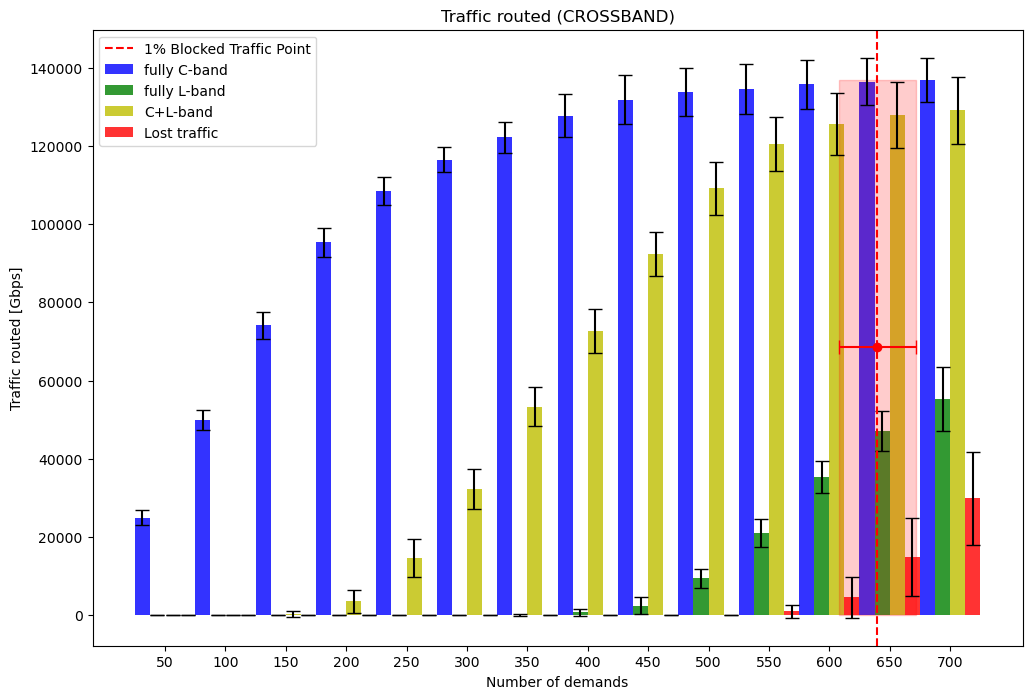

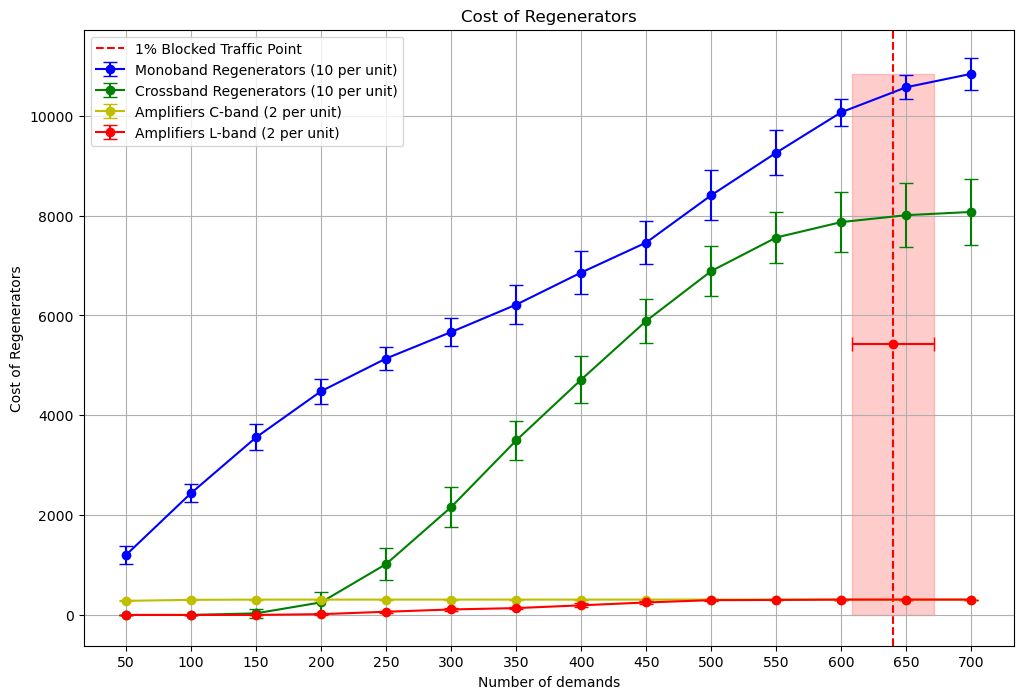

In [17]:

# Print the results with matplotlib in a histogram with three bars per each heuristicResults tuple, one bar per each band and one for lost traffic
# The bar will represent the traffic routed on c band and l band
# The x axis will represent the number of demands
# The y axis will represent the traffic routed
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25 # Adjust the bar width to fit all bars without overlapping
index = np.arange(len(heuristicResults_cross))  # Assuming heuristicResults is a list
opacity = 0.8
# Plotting the results with error bars
mean_traffic_c = [result[0] for result in results_list_cross]
std_traffic_c = [result[1] for result in results_list_cross]
mean_traffic_l = [result[2] for result in results_list_cross]
std_traffic_l = [result[3] for result in results_list_cross]
mean_traffic_c_l = [result[4] for result in results_list_cross]
std_traffic_c_l = [result[5] for result in results_list_cross]
mean_lost_traffic = [result[6] for result in results_list_cross]
std_lost_traffic = [result[7] for result in results_list_cross]

rects1 = plt.bar(index - 1.5 * bar_width, mean_traffic_c, bar_width,
                 alpha=opacity,
                 color='b',
                 label='fully C-band',
                 yerr=std_traffic_c,
                 capsize=5)

rects2 = plt.bar(index - 0.5 * bar_width, mean_traffic_l, bar_width,
                 alpha=opacity,
                 color='g',
                 label='fully L-band',
                 yerr=std_traffic_l,
                 capsize=5)

rects4 = plt.bar(index + 0.5 * bar_width, mean_traffic_c_l, bar_width,
                 alpha=opacity,
                 color='y',
                 label='C+L-band',
                 yerr=std_traffic_c_l,
                 capsize=5)

rects3 = plt.bar(index + 1.5 * bar_width, mean_lost_traffic, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Lost traffic',
                 yerr=std_lost_traffic,
                 capsize=5)

# Adding uncertainty to the vertical line
if one_percent_cross_avg:
    ax.axvline(x=one_percent_cross_avg, color='r', linestyle='--', label='1% Blocked Traffic Point')
    ax.fill_betweenx([0, max(mean_traffic_c + mean_traffic_l + mean_traffic_c_l + mean_lost_traffic)], 
                     one_percent_cross_avg - one_percent_cross_std, 
                     one_percent_cross_avg + one_percent_cross_std, 
                     color='r', alpha=0.2)
    ax.errorbar(x=one_percent_cross_avg,y= max(mean_traffic_c + mean_traffic_l + mean_traffic_c_l + mean_lost_traffic)/2, xerr=one_percent_cross_std, fmt='o', color='r', capsize=5)

plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Traffic routed [Gbps]')
plt.title('Traffic routed (CROSSBAND)')
plt.legend()

mean_mono_regen = [result[8] for result in results_list_cross]
std_mono_regen = [result[9] for result in results_list_cross]
mean_cross_regen = [result[10] for result in results_list_cross]
std_cross_regen = [result[11] for result in results_list_cross]
mean_c_amplifiers = [result[12] for result in results_list_cross]
std_c_amplifiers = [result[13] for result in results_list_cross]
mean_l_amplifiers = [result[14] for result in results_list_cross]
std_l_amplifiers = [result[15] for result in results_list_cross]

fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(heuristicResults_cross))  # Assuming heuristicResults is a list

# Plotting the cost of monoband regenerat

# Monoband regenerators
ax.errorbar(index, [cost_mono_regen * mean for mean in mean_mono_regen],
            yerr= [cost_mono_regen * std for std in std_mono_regen],
            fmt='o-',  # Format line and marker
            color='b',
            label='Monoband Regenerators ('+str(cost_mono_regen)+' per unit)',
            capsize=5)

# Crossband regenerators
ax.errorbar(index, [cost_cross_regen * mean for mean in mean_cross_regen],
            yerr= [cost_cross_regen * std for std in std_cross_regen],
            fmt='o-',  # Format line and marker
            color='g',
            label='Crossband Regenerators ('+str(cost_cross_regen)+' per unit)',
            capsize=5)

# Amplifiers C-band
ax.errorbar(index, [cost_amplifiers * mean for mean in mean_c_amplifiers],
            yerr= [cost_amplifiers * std for std in std_c_amplifiers],
            fmt='o-',  # Format line and marker
            color='y',
            label='Amplifiers C-band ('+str(cost_amplifiers)+' per unit)',
            capsize=5)

# Amplifiers L-band
ax.errorbar(index, [cost_amplifiers * mean for mean in mean_l_amplifiers],
            yerr= [cost_amplifiers * std for std in std_l_amplifiers],
            fmt='o-',  # Format line and marker
            color='r',
            label='Amplifiers L-band ('+str(cost_amplifiers)+' per unit)',
            capsize=5)

if one_percent_cross_avg:
    ax.axvline(x=one_percent_cross_avg, color='r', linestyle='--', label='1% Blocked Traffic Point')
    ax.fill_betweenx([0, max(cost_mono_regen * max(mean_mono_regen),cost_cross_regen * max(mean_cross_regen))], 
                     one_percent_cross_avg - one_percent_cross_std, 
                     one_percent_cross_avg + one_percent_cross_std, 
                     color='r', alpha=0.2)
    ax.errorbar(x=one_percent_cross_avg,y= cost_mono_regen * max(mean_mono_regen)/2, xerr=one_percent_cross_std, fmt='o', color='r', capsize=5)


plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Cost of Regenerators')
plt.title('Cost of Regenerators')
plt.grid()
plt.legend()

one_percent_block_cross = round(one_percent_cross_avg) 
opbc = one_percent_block_cross
print('____________________________________________________________________________________')
print('SUMMARY for CROSSBAND:\n')
print(f'At 1% blocked traffic, on average:')
print(f'- We are using {round(mean_mono_regen[opbc],2)} monoband regenerators')
print(f'- We are using {round(mean_cross_regen[opbc],2)} crossband regenerators')
print(f'- We are using {round(mean_c_amplifiers[opbc],2)} amplifiers for the C-band')
print(f'- We are using {round(mean_l_amplifiers[opbc],2)} amplifiers for the L-band')
print(f'Cost of monoband regenerators of: {round(mean_mono_regen[opbc] * cost_mono_regen,2)} ({cost_mono_regen} per unit)')
print(f'Cost of crossband regenerators of: {round(mean_cross_regen[opbc] * cost_cross_regen,2)} ({cost_cross_regen} per unit)')
print(f'Cost of amplifiers for the C-band of: {round(mean_c_amplifiers[opbc] * cost_amplifiers)} ({cost_amplifiers} per unit)')
print(f'Cost of amplifiers for the L-band of: {round(mean_l_amplifiers[opbc] * cost_amplifiers)} ({cost_amplifiers} per unit)')
print(f'We routed a total of {round(mean_traffic_c[opbc]+mean_traffic_l[opbc]+mean_traffic_c_l[opbc],2)} Gbps of traffic out of a total of {round(mean_traffic_c[opbc]+mean_traffic_l[opbc]+mean_traffic_c_l[opbc]+mean_lost_traffic[opbc],2)} Gpbs')
# print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
# print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
print('____________________________________________________________________________________')
if edge_usage:
    for edge in G.edges:
        if dualband:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nC-Band wavelength utilization: {G.edges[edge]["c_available_wavelengths"]}\nL-Band wavelength utilization: {G.edges[edge]["l_available_wavelengths"]}')
        else:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')


____________________________________________________________________________________
SUMMARY NO CROSSBAND:

At 1% blocked traffic, on average:
- We are using 1205.0 monoband regenerators
- We are using 0 crossband regenerators
- We are using 154.0 amplifiers for the C-band
- We are using 154.0 amplifiers for the L-band
Cost of monoband regenerators of: 12050.0 (10 per unit)
Cost of crossband regenerators of: 0 (10 per unit)
Cost of amplifiers for the C-band of: 308 (2 per unit)
Cost of amplifiers for the L-band of: 308 (2 per unit)
We routed a total of 245600.0 Gbps of traffic out of a total of 252377.78 Gpbs
____________________________________________________________________________________


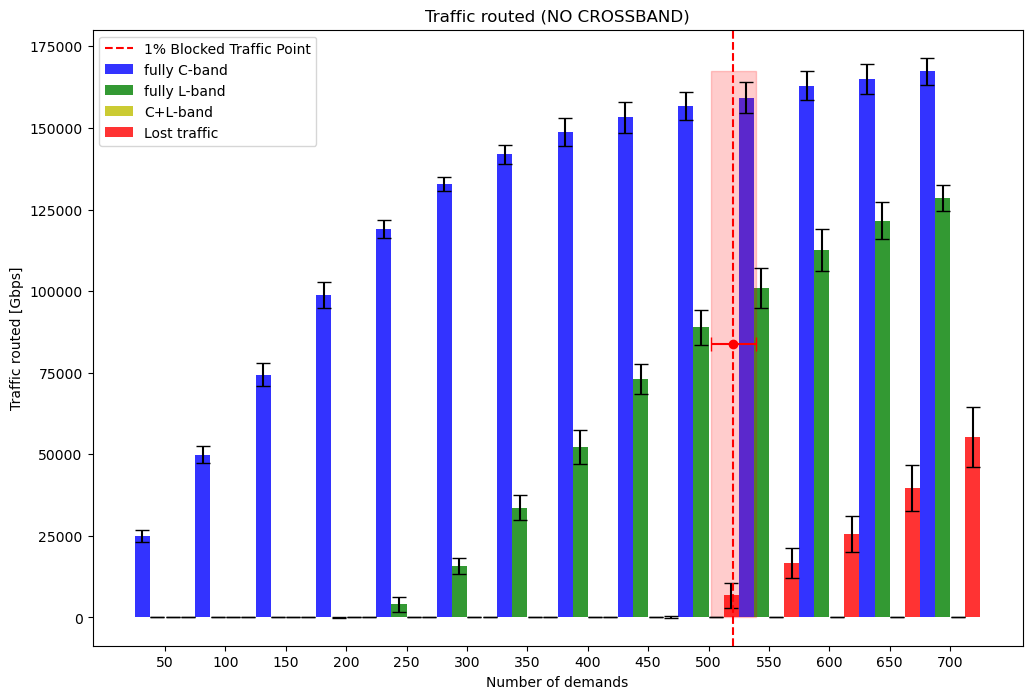

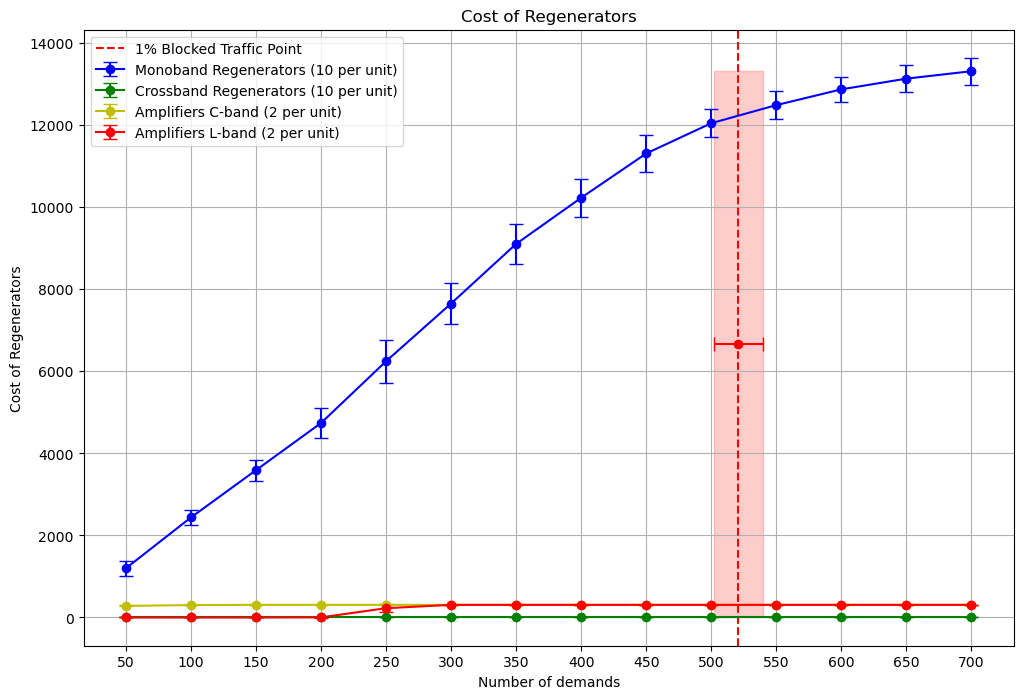

In [18]:

# Print the results with matplotlib in a histogram with three bars per each heuristicResults tuple, one bar per each band and one for lost traffic
# The bar will represent the traffic routed on c band and l band
# The x axis will represent the number of demands
# The y axis will represent the traffic routed
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25 # Adjust the bar width to fit all bars without overlapping
index = np.arange(len(heuristicResults_cross))  # Assuming heuristicResults is a list
opacity = 0.8
# Plotting the results with error bars
mean_traffic_c = [result[0] for result in results_list_mono]
std_traffic_c = [result[1] for result in results_list_mono]
mean_traffic_l = [result[2] for result in results_list_mono]
std_traffic_l = [result[3] for result in results_list_mono]
mean_traffic_c_l = [result[4] for result in results_list_mono]
std_traffic_c_l = [result[5] for result in results_list_mono]
mean_lost_traffic = [result[6] for result in results_list_mono]
std_lost_traffic = [result[7] for result in results_list_mono]

rects1 = plt.bar(index - 1.5 * bar_width, mean_traffic_c, bar_width,
                 alpha=opacity,
                 color='b',
                 label='fully C-band',
                 yerr=std_traffic_c,
                 capsize=5)

rects2 = plt.bar(index - 0.5 * bar_width, mean_traffic_l, bar_width,
                 alpha=opacity,
                 color='g',
                 label='fully L-band',
                 yerr=std_traffic_l,
                 capsize=5)

rects4 = plt.bar(index + 0.5 * bar_width, mean_traffic_c_l, bar_width,
                 alpha=opacity,
                 color='y',
                 label='C+L-band',
                 yerr=std_traffic_c_l,
                 capsize=5)

rects3 = plt.bar(index + 1.5 * bar_width, mean_lost_traffic, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Lost traffic',
                 yerr=std_lost_traffic,
                 capsize=5)

# Adding uncertainty to the vertical line
if one_percent_mono_avg:
    ax.axvline(x=one_percent_mono_avg, color='r', linestyle='--', label='1% Blocked Traffic Point')
    ax.fill_betweenx([0, max(mean_traffic_c + mean_traffic_l + mean_lost_traffic)], 
                     one_percent_mono_avg - one_percent_mono_std, 
                     one_percent_mono_avg + one_percent_mono_std, 
                     color='r', alpha=0.2)
    ax.errorbar(x=one_percent_mono_avg,y= max(mean_traffic_c + mean_traffic_l + mean_lost_traffic)/2, xerr=one_percent_mono_std, fmt='o', color='r', capsize=5)

plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Traffic routed [Gbps]')
plt.title('Traffic routed (NO CROSSBAND)')
plt.legend()

mean_mono_regen = [result[8] for result in results_list_mono]
std_mono_regen = [result[9] for result in results_list_mono]
mean_cross_regen = [result[10] for result in results_list_mono]
std_cross_regen = [result[11] for result in results_list_mono]
mean_c_amplifiers = [result[12] for result in results_list_mono]
std_c_amplifiers = [result[13] for result in results_list_mono]
mean_l_amplifiers = [result[14] for result in results_list_mono]
std_l_amplifiers = [result[15] for result in results_list_mono]

fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(heuristicResults_mono))  # Assuming heuristicResults is a list

# Plotting the cost of monoband regenerat

# Monoband regenerators
ax.errorbar(index, [cost_mono_regen * mean for mean in mean_mono_regen],
            yerr= [cost_mono_regen * std for std in std_mono_regen],
            fmt='o-',  # Format line and marker
            color='b',
            label='Monoband Regenerators ('+str(cost_mono_regen)+' per unit)',
            capsize=5)

# Crossband regenerators
ax.errorbar(index, [cost_cross_regen * mean for mean in mean_cross_regen],
            yerr= [cost_cross_regen * std for std in std_cross_regen],
            fmt='o-',  # Format line and marker
            color='g',
            label='Crossband Regenerators ('+str(cost_cross_regen)+' per unit)',
            capsize=5)

# Amplifiers C-band
ax.errorbar(index, [cost_amplifiers * mean for mean in mean_c_amplifiers],
            yerr= [cost_amplifiers * std for std in std_c_amplifiers],
            fmt='o-',  # Format line and marker
            color='y',
            label='Amplifiers C-band ('+str(cost_amplifiers)+' per unit)',
            capsize=5)

# Amplifiers L-band
ax.errorbar(index, [cost_amplifiers * mean for mean in mean_l_amplifiers],
            yerr= [cost_amplifiers * std for std in std_l_amplifiers],
            fmt='o-',  # Format line and marker
            color='r',
            label='Amplifiers L-band ('+str(cost_amplifiers)+' per unit)',
            capsize=5)

if one_percent_mono_avg:
    ax.axvline(x=one_percent_mono_avg, color='r', linestyle='--', label='1% Blocked Traffic Point')
    ax.fill_betweenx([0, max(cost_mono_regen * max(mean_mono_regen),cost_cross_regen * max(mean_cross_regen))], 
                     one_percent_mono_avg - one_percent_mono_std, 
                     one_percent_mono_avg + one_percent_mono_std, 
                     color='r', alpha=0.2)
    ax.errorbar(x=one_percent_mono_avg,y= cost_mono_regen * max(mean_mono_regen)/2, xerr=one_percent_mono_std, fmt='o', color='r', capsize=5)

plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Cost of Regenerators')
plt.title('Cost of Regenerators')
plt.grid()
plt.legend()

one_percent_block_mono = round(one_percent_mono_avg) 
opbm = one_percent_block_mono
print('____________________________________________________________________________________')
print('SUMMARY NO CROSSBAND:\n')
print(f'At 1% blocked traffic, on average:')
print(f'- We are using {round(mean_mono_regen[opbm],2)} monoband regenerators')
print(f'- We are using {round(mean_cross_regen[opbm],2)} crossband regenerators')
print(f'- We are using {round(mean_c_amplifiers[opbm],2)} amplifiers for the C-band')
print(f'- We are using {round(mean_l_amplifiers[opbm],2)} amplifiers for the L-band')
print(f'Cost of monoband regenerators of: {round(mean_mono_regen[opbm] * cost_mono_regen,2)} ({cost_mono_regen} per unit)')
print(f'Cost of crossband regenerators of: {round(mean_cross_regen[opbm] * cost_cross_regen,2)} ({cost_cross_regen} per unit)')
print(f'Cost of amplifiers for the C-band of: {round(mean_c_amplifiers[opbm] * cost_amplifiers)} ({cost_amplifiers} per unit)')
print(f'Cost of amplifiers for the L-band of: {round(mean_l_amplifiers[opbm] * cost_amplifiers)} ({cost_amplifiers} per unit)')
print(f'We routed a total of {round(mean_traffic_c[opbm]+mean_traffic_l[opbm]+mean_traffic_c_l[opbm],2)} Gbps of traffic out of a total of {round(mean_traffic_c[opbm]+mean_traffic_l[opbm]+mean_traffic_c_l[opbm]+mean_lost_traffic[opbm],2)} Gpbs')
# print(f'We blocked {total_demands-total_demands_routed} demands out of {total_demands}, representing {round(blocked_percentage,2)}% of requests')
# print(f'That represents a percentage of {round(blocked_traffic,2)}%  lost traffic')
print('____________________________________________________________________________________')
if edge_usage:
    for edge in G.edges:
        if dualband:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nC-Band wavelength utilization: {G.edges[edge]["c_available_wavelengths"]}\nL-Band wavelength utilization: {G.edges[edge]["l_available_wavelengths"]}')
        else:
            print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')


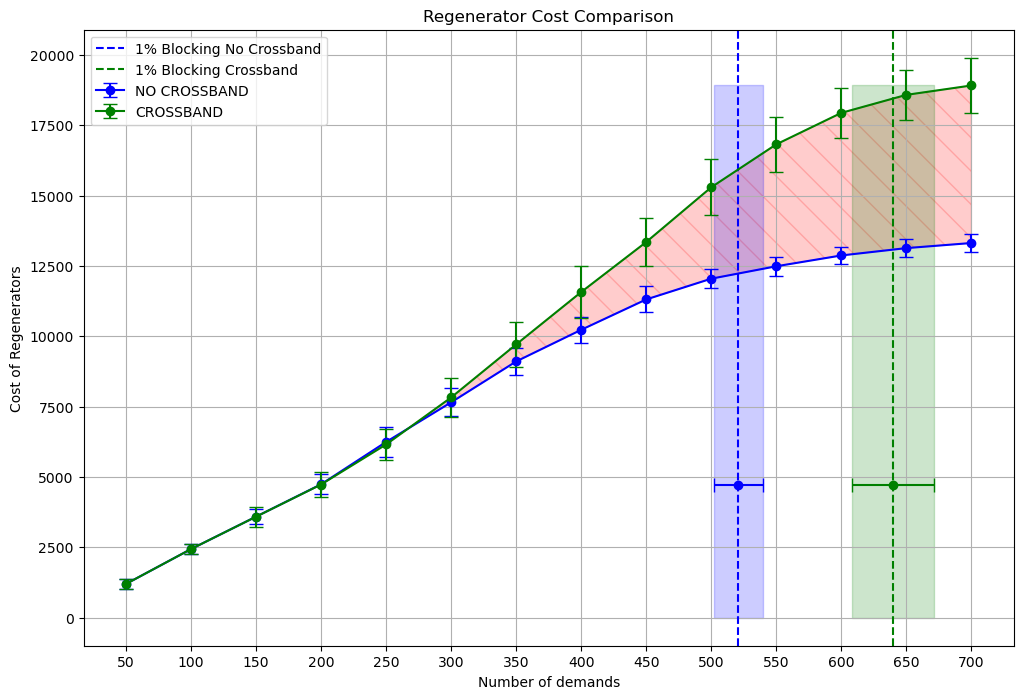

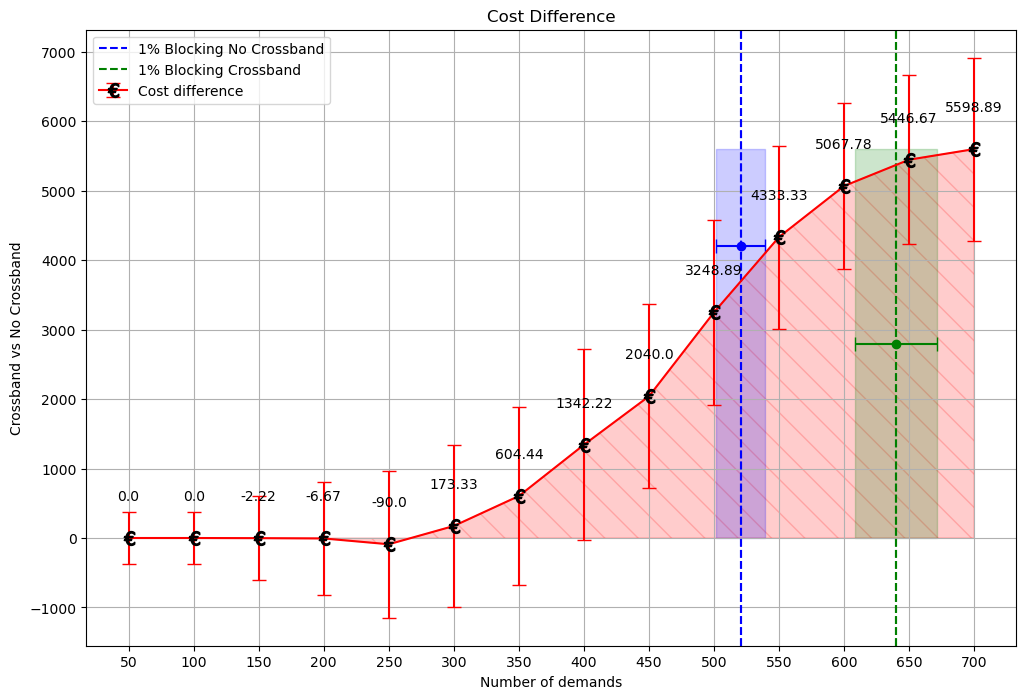

In [19]:

mean_mono_regen_mono = [result[8] for result in results_list_mono]
std_mono_regen_mono = [result[9] for result in results_list_mono]

mean_mono_regen_cross = [result[8] for result in results_list_cross]
std_mono_regen_cross = [result[9] for result in results_list_cross]
mean_cross_regen_cross = [result[10] for result in results_list_cross]
std_cross_regen_cross = [result[11] for result in results_list_cross]

fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(heuristicResults_mono))  # Assuming heuristicResults is a list


# NON-CROSSBAND 
ax.errorbar(index, [cost_mono_regen * mean for mean in mean_mono_regen_mono],
            yerr= [cost_mono_regen * std for std in std_mono_regen_mono],
            fmt='o-',  # Format line and marker
            color='b',
            label='NO CROSSBAND',
            capsize=5)

# CROSSBAND 
ax.errorbar(index, [(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) for i in range(len(mean_mono_regen_cross))],
            yerr= [(cost_mono_regen * std_mono_regen_cross[i]) + (cost_cross_regen * std_cross_regen_cross[i]) for i in range(len(std_cross_regen_cross))],
            fmt='o-',  # Format line and marker
            color='g',
            label='CROSSBAND',
            capsize=5)

# Fill area between the two curves
plt.fill_between(index, [(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) for i in range(len(mean_mono_regen_cross))],
                    [cost_mono_regen * mean for mean in mean_mono_regen_mono],
                    color='r', 
                    hatch= '\\',
                    alpha=0.2)

if one_percent_mono_avg:
    ax.axvline(x=one_percent_mono_avg, color='b', linestyle='--', label='1% Blocking No Crossband')
    ax.fill_betweenx([0, max(cost_mono_regen * max(mean_mono_regen_mono), cost_mono_regen * max(mean_mono_regen_cross) + cost_cross_regen * max(mean_cross_regen_cross))], 
                     one_percent_mono_avg - one_percent_mono_std, 
                     one_percent_mono_avg + one_percent_mono_std, 
                     color='b', alpha=0.2)
    ax.errorbar(x=one_percent_mono_avg,y= max(cost_mono_regen * max(mean_mono_regen_mono), cost_mono_regen * max(mean_mono_regen_cross) + cost_cross_regen * max(mean_cross_regen_cross))/4, xerr=one_percent_mono_std, fmt='o', color='b', capsize=5)

if one_percent_cross_avg:
    ax.axvline(x=one_percent_cross_avg, color='g', linestyle='--', label='1% Blocking Crossband')
    ax.fill_betweenx([0, max(cost_mono_regen * max(mean_mono_regen_mono), cost_mono_regen * max(mean_mono_regen_cross) + cost_cross_regen * max(mean_cross_regen_cross))], 
                     one_percent_cross_avg - one_percent_cross_std, 
                     one_percent_cross_avg + one_percent_cross_std, 
                     color='g', alpha=0.2)
    ax.errorbar(x=one_percent_cross_avg,y= max(cost_mono_regen * max(mean_mono_regen_mono), cost_mono_regen * max(mean_mono_regen_cross) + cost_cross_regen * max(mean_cross_regen_cross))/4, xerr=one_percent_cross_std, fmt='o', color='g', capsize=5)

plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Cost of Regenerators')
plt.title('Regenerator Cost Comparison')
plt.grid()
plt.legend()



#Difference

fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(len(heuristicResults_mono))  # Assuming heuristicResults is a list

ax.errorbar(index, [(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))],
            yerr= [(cost_mono_regen * std_mono_regen_cross[i]) + (cost_cross_regen * std_cross_regen_cross[i]) + cost_mono_regen * std_mono_regen_mono[i] for i in range(len(std_cross_regen_cross))],
            marker=r"$€$", 
            markersize=10,
            mec='black', mfc='black',
            color='r',
            label='Cost difference',
            capsize=5)

# Label each point
for i in range(len(index)):
    ax.text(index[i], (cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] + 500, 
            f"{round((cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i], 2)}",
            ha='center', va='bottom', fontsize=10)

# Fill the area under the curve
plt.fill_between(index, [(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))], 0, 
                color='r',
                hatch= '\\',
                alpha=0.2)


if one_percent_mono_avg:
    ax.axvline(x=one_percent_mono_avg, color='b', linestyle='--', label='1% Blocking No Crossband')
    ax.fill_betweenx([0, max([(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))])], 
                     one_percent_mono_avg - one_percent_mono_std, 
                     one_percent_mono_avg + one_percent_mono_std, 
                     color='b', alpha=0.2)
    plt.axvline(x = one_percent_mono_avg, color='b', linestyle='--')
    ax.errorbar(x=one_percent_mono_avg,y= max([(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))])*0.75, xerr=one_percent_mono_std, fmt='o', color='b', capsize=5)

if one_percent_cross_avg:
    ax.axvline(x=one_percent_cross_avg, color='g', linestyle='--', label='1% Blocking Crossband')
    ax.fill_betweenx([0, max([(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))])], 
                     one_percent_cross_avg - one_percent_cross_std, 
                     one_percent_cross_avg + one_percent_cross_std, 
                     color='g', alpha=0.2)
    plt.axvline(x = one_percent_cross_avg, color='g', linestyle='--')    
    ax.errorbar(x=one_percent_cross_avg,y= max([(cost_mono_regen * mean_mono_regen_cross[i]) + (cost_cross_regen * mean_cross_regen_cross[i]) - cost_mono_regen * mean_mono_regen_mono[i] for i in range(len(mean_mono_regen_cross))])/2, xerr=one_percent_cross_std, fmt='o', color='g', capsize=5)

plt.xticks(index, [(i + 1) * demand_at_a_time for i in index])
plt.xlabel('Number of demands')
plt.ylabel('Crossband vs No Crossband')
plt.title('Cost Difference')
plt.grid()
plt.legend()


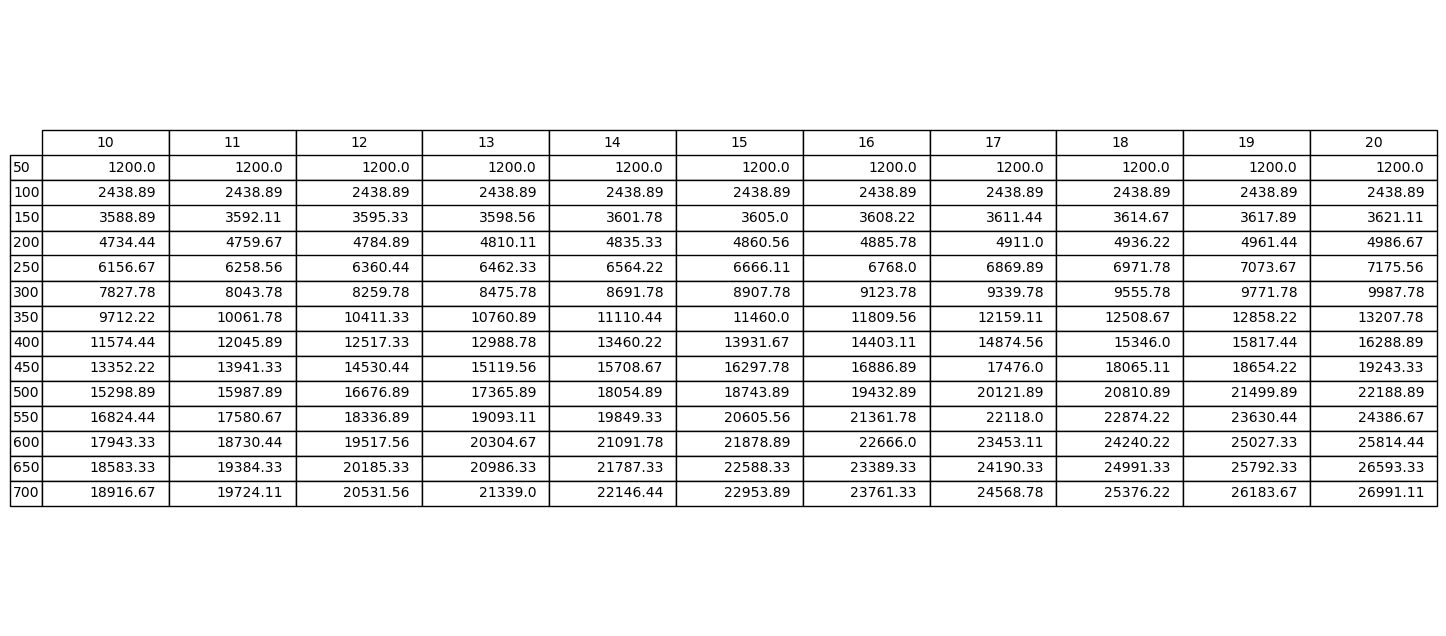

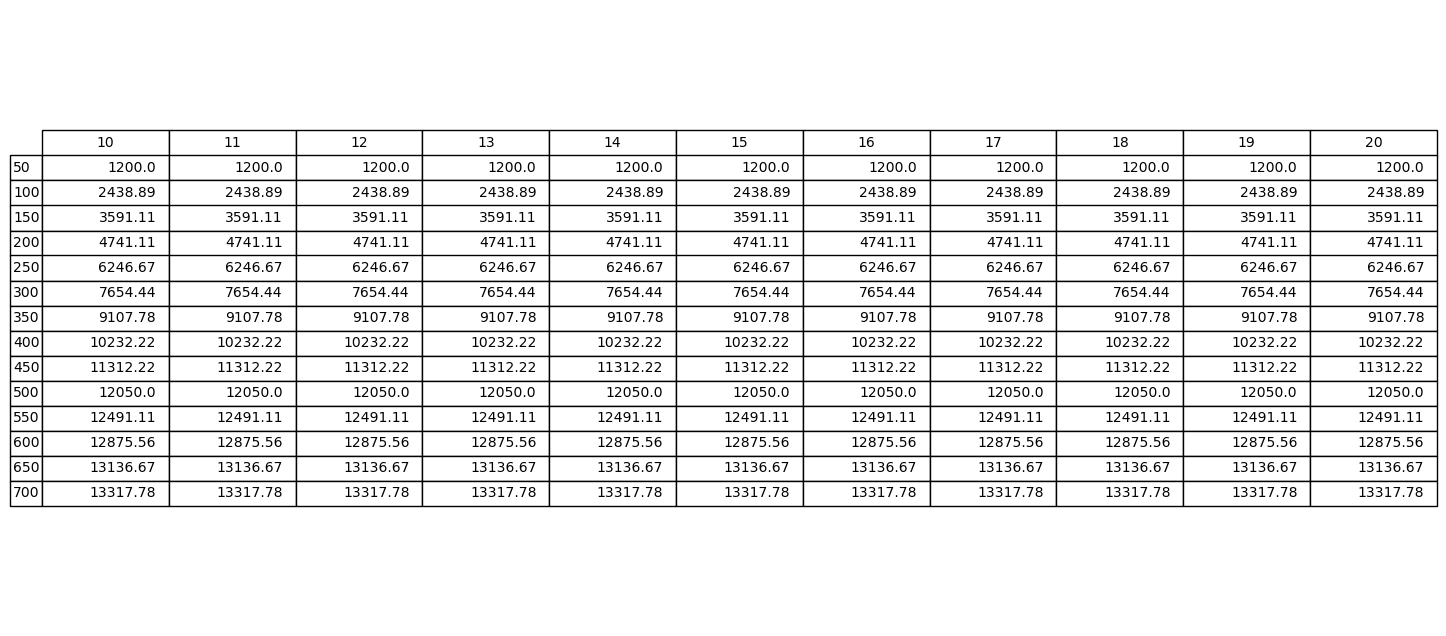

In [ ]:
cross_regen_total_cost = []
mono_regen_total_cost = []
cost_mono = 10

for iteration in results_list_cross:
    cross_regen_total_cost.append([round(cost_cross * iteration[10] + cost_mono * iteration[8], 2) for cost_cross in range(10,21)]) 
for iteration in results_list_mono:
    mono_regen_total_cost.append([round(cost_cross * iteration[10] + cost_mono * iteration[8], 2) for cost_cross in range(10,21)])

# Plot it in a nice table
fig, ax = plt.subplots(figsize=(12, 8))

# Create a table
table = plt.table(cellText=cross_regen_total_cost,
                  rowLabels=[(i + 1) * demand_at_a_time for i in range(len(cross_regen_total_cost))],
                  colLabels=[cost_cross for cost_cross in range(10,21)],
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)

plt.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

# Create a table
table = plt.table(cellText=mono_regen_total_cost,
                  rowLabels=[(i + 1) * demand_at_a_time for i in range(len(mono_regen_total_cost))],
                  colLabels=[cost_cross for cost_cross in range(10,21)],
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)

plt.axis('off')
plt.show()

